# LSTM实现分类任务

## 数据集获取

本次使用数据集为`MNIST`数据集，为了方便起见，这次数据集的读取采用

## 导入必要的包

In [2]:
import paddle
import paddle.nn as nn
import numpy as np
import os
from paddle.vision.datasets import MNIST
from paddle.io import Dataset
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

paddle.__version__

'2.0.0-rc1'

## 数据处理

In [2]:
train_dataset = MNIST(mode='train')
val_dataset = MNIST(mode='test')

In [3]:
def plot_num_images(num):
    if num < 1:
        print('INFO:The number of input pictures must be greater than zero!')
    else:
        choose_list = []
        for i in range(num):
            choose_n = np.random.randint(len(train_dataset))
            choose_list.append(choose_n)
        fig = plt.gcf()
        fig.set_size_inches(18, 5)
        for i in range(num):
            ax_img = plt.subplot(2, 8, i + 1)
            plt_img = train_dataset[choose_list[i]][0]
            ax_img.imshow(plt_img, cmap='binary')
            ax_img.set_title(str(train_dataset[choose_list[i]][1].item()),
                             fontsize=10)
        plt.show()

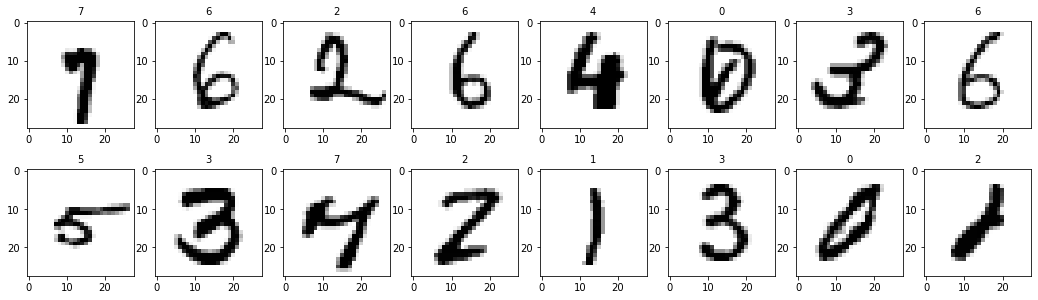

In [4]:
plot_num_images(16)

## 数据装载

In [5]:
class MnnistDataset(Dataset):
    def __init__(self, mode='train'):
        super(MnnistDataset, self).__init__()
        if mode == 'train':
            self.data = [[np.array(train_dataset[i][0]).astype('float32'), train_dataset[i][1].astype('int64')] for i in range(len(train_dataset))]
        else:
            self.data = [[np.array(val_dataset[i][0]).astype('float32'), val_dataset[i][1].astype('int64')] for i in range(len(val_dataset))]

    def __getitem__(self, index):
        data = self.data[index][0]
        label = self.data[index][1]

        return data, label

    def __len__(self):
        return len(self.data)

In [57]:
train_loader = paddle.io.DataLoader(MnnistDataset(mode='train'), batch_size=10000, shuffle=True)
val_loader = paddle.io.DataLoader(MnnistDataset(mode='val'), batch_size=10000, shuffle=True)

## 建模训练

In [7]:
class RNN(nn.Layer):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(
            input_size=28,
            hidden_size=64,
            num_layers=1,
        )
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)
        out = self.out(r_out[:, -1, :])
        
        return out

In [8]:
epochs = 20
batch_size = 32

In [16]:
paddle.summary(RNN(), (1, 28, 28))

----------------------------------------------------------------------------------------------
 Layer (type)       Input Shape                   Output Shape                   Param #    
    LSTM-6      [[1, 28, 28], None]  [[1, 28, 64], [[1, 1, 64], [1, 1, 64]]]     24,064     
   Linear-6          [[1, 64]]                       [1, 10]                       650      
Total params: 24,714
Trainable params: 24,714
Non-trainable params: 0
----------------------------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.09
Estimated Total Size (MB): 0.14
----------------------------------------------------------------------------------------------



{'total_params': 24714, 'trainable_params': 24714}

In [17]:
model = paddle.Model(RNN())

model.prepare(optimizer=paddle.optimizer.Adam(learning_rate=0.005, parameters=model.parameters()),
              loss=paddle.nn.CrossEntropyLoss(),
              metrics=paddle.metric.Accuracy())

model.fit(train_loader,
          val_loader,
          epochs=epochs,
          batch_size=batch_size,
          verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/20
step 6/6 [==============================] - loss: 1.9152 - acc: 0.3026 - 400ms/step
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 1/1 [==============================] - loss: 1.8194 - acc: 0.4652 - 381ms/step
Eval samples: 10000
Epoch 2/20
step 6/6 [==============================] - loss: 1.3814 - acc: 0.5162 - 260ms/step
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 1/1 [==============================] - loss: 1.2895 - acc: 0.6251 - 217ms/step
Eval samples: 10000
Epoch 3/20
step 6/6 [==============================] - loss: 0.9554 - acc: 0.6603 - 285ms/step
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 1/1 [================

In [18]:
model.evaluate(val_loader)

Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 1/1 - loss: 0.2984 - acc: 0.8977 - 307ms/step
Eval samples: 10000


{'loss': [0.29836994], 'acc': 0.8977}

# LSTM实现回归任务

## 数据集获取

数据集可在[AIStudio平台](https://aistudio.baidu.com/aistudio/datasetdetail/68632)进行下载
**波士顿房价数据集包括506个样本，每个样本包括12个特征变量和该地区的平均房价，房价（单价）显然和多个特征变量相关，不是单变量线性回归（一元线性回归）问题，选择多个特征变量来建立线性方程，这就是多变量线性回归（多元线性回归）问题**

|变量| 含义 |
|--|--|
| CRIM | 城镇人均犯罪率 |
| ZN| 住宅用地超过25,000平方英尺以上的比例 |
| INDUS| 城镇非零售商用土地的比例（即工业或农业等用地比例） |
| CHAS| 查尔斯河虚拟变量（边界是河，则为1；否则为0） |
| NOX | 一氧化氮浓度（百万分之几） |
| RM| 每个住宅的平均房间数 |
| AGE| 1940 年之前建成的自用房屋比例 |
| DIS| 到波士顿五个中心区域的加权距离（与繁华闹市的距离，区分郊区与市区） |
| RAD| 高速公路通行能力指数（辐射性公路的靠近指数） |
| TAX | 每10,000美元的全额财产税率 |
| PTRATIO| 按镇划分的城镇师生比例 |
| B | 1000(Bk-0.63)^2其中Bk是城镇黑人比例 |
| LSTAT| 人口中地位低下者的百分比 |
| MEDV| 自有住房的中位数价值（单位：千美元） |

In [3]:
import pandas as pd

In [4]:
paddle.seed(7)

data_frame = pd.read_csv('./housing.csv', header=None)

In [5]:
all_data = []

for column in range(len(data_frame)):
    column_data = []
    for data in list(data_frame.iloc[column])[0].split(' '):
        if data != '':
            column_data.append(float(data))
    all_data.append(column_data)

all_data = np.array(all_data)

In [6]:
x_data = all_data[:, :13]
y_data = all_data[:, 13]

In [7]:
print('x_data:\n', x_data, '\n x_data shape:', x_data.shape,
      '\ny_data:\n', y_data, '\n y_data shape:', y_data.shape)

x_data:
 [[6.3200e-03 1.8000e+01 2.3100e+00 ... 1.5300e+01 3.9690e+02 4.9800e+00]
 [2.7310e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9690e+02 9.1400e+00]
 [2.7290e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9283e+02 4.0300e+00]
 ...
 [6.0760e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 5.6400e+00]
 [1.0959e-01 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9345e+02 6.4800e+00]
 [4.7410e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 7.8800e+00]] 
 x_data shape: (506, 13) 
y_data:
 [24.  21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 15.  18.9 21.7 20.4
 18.2 19.9 23.1 17.5 20.2 18.2 13.6 19.6 15.2 14.5 15.6 13.9 16.6 14.8
 18.4 21.  12.7 14.5 13.2 13.1 13.5 18.9 20.  21.  24.7 30.8 34.9 26.6
 25.3 24.7 21.2 19.3 20.  16.6 14.4 19.4 19.7 20.5 25.  23.4 18.9 35.4
 24.7 31.6 23.3 19.6 18.7 16.  22.2 25.  33.  23.5 19.4 22.  17.4 20.9
 24.2 21.7 22.8 23.4 24.1 21.4 20.  20.8 21.2 20.3 28.  23.9 24.8 22.9
 23.9 26.6 22.5 22.2 23.6 28.7 22.6 22.  22.9 25.  20.6 28.4 21.4 38.7
 43.8 33.2 27.

## 数据集装载

In [8]:
class BreastDataset(Dataset):
    def __init__(self, mode='train'):
        super(BreastDataset, self).__init__()
        self.data = [[x_data[i].reshape(-1, 1).astype('float32'), y_data[i].astype('float32')] for i in range(x_data.shape[0])]

    def __getitem__(self, index):
        data = self.data[index][0]
        label = self.data[index][1]

        return data, label

    def __len__(self):
        return len(self.data)

In [9]:
train_loader = paddle.io.DataLoader(BreastDataset(mode='train'), batch_size=100, shuffle=True)

## 建模训练

In [10]:
class BreastRNN(nn.Layer):
    def __init__(self):
        super(BreastRNN, self).__init__()

        self.rnn = nn.LSTM(
            input_size=1,
            hidden_size=64,
            num_layers=1,
        )
        self.out = nn.Linear(64, 1)

    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)
        out = self.out(r_out[:, -1, :])
        
        return out

In [11]:
paddle.summary(BreastRNN(), (1, 13, 1))

----------------------------------------------------------------------------------------------
 Layer (type)       Input Shape                   Output Shape                   Param #    
    LSTM-1       [[1, 13, 1], None]  [[1, 13, 64], [[1, 1, 64], [1, 1, 64]]]     17,152     
   Linear-1          [[1, 64]]                       [1, 1]                        65       
Total params: 17,217
Trainable params: 17,217
Non-trainable params: 0
----------------------------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.07
Estimated Total Size (MB): 0.10
----------------------------------------------------------------------------------------------



{'total_params': 17217, 'trainable_params': 17217}

In [14]:
epochs = 20
batch_size = 32

In [15]:
model = paddle.Model(BreastRNN())

model.prepare(optimizer=paddle.optimizer.Adam(learning_rate=0.005, parameters=model.parameters()),
              loss=paddle.nn.MSELoss())

model.fit(train_loader,
          epochs=epochs,
          batch_size=batch_size,
          verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/20
step 6/6 [==============================] - loss: 846.5749 - 12ms/step
Epoch 2/20
step 6/6 [==============================] - loss: 464.9476 - 8ms/step
Epoch 3/20
step 6/6 [==============================] - loss: 152.8017 - 9ms/step
Epoch 4/20
step 6/6 [==============================] - loss: 322.6063 - 8ms/step
Epoch 5/20
step 6/6 [==============================] - loss: 77.3828 - 8ms/step
Epoch 6/20
step 6/6 [==============================] - loss: 51.7485 - 9ms/step
Epoch 7/20
step 6/6 [==============================] - loss: 247.1716 - 9ms/step
Epoch 8/20
step 6/6 [==============================] - loss: 66.1677 - 12ms/step
Epoch 9/20
step 6/6 [==============================] - loss: 19.2254 - 8ms/step
Epoch 10/20
step 6/6 [==============================] - loss: 55.7542 - 10ms/step
Epoch 11/20
step 6/6 [==============================] - loss: 103.3308 - 10ms/step